In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import os
from pydataset import data
from math import sqrt
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
#from sklearn.tree import export_graphviz
import sklearn.metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import acquire
import env
import explore
import prepare

import graphviz
from graphviz import Graph

In [2]:
#sns.set(rc={'figure.figsize':(11.7,8.27)})

Project Objectives

Document code, process (data acquistion, preparation, exploratory data analysis and statistical testing, modeling, and model evaluation), findings, and key takeaways in a Jupyter Notebook report.

Create modules (acquire.py, prepare.py) that make your process repeateable.

Construct a model to predict customer churn using classification techniques.

In [3]:
#acquire the data

df = pd.read_sql('''SELECT *
FROM customers
JOIN contract_types USING(contract_type_id)
JOIN internet_service_types USING(internet_service_type_id)
JOIN payment_types USING(payment_type_id);''', acquire.get_connection("telco_churn"))

In [4]:
df.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,3,0016-QLJIS,Female,0,Yes,Yes,65,Yes,...,Yes,Yes,Yes,Yes,90.45,5957.9,No,Two year,DSL,Mailed check
1,4,1,3,0017-DINOC,Male,0,No,No,54,No,...,Yes,Yes,No,No,45.20,2460.55,No,Two year,DSL,Credit card (automatic)
2,3,1,3,0019-GFNTW,Female,0,No,No,56,No,...,Yes,No,No,No,45.05,2560.1,No,Two year,DSL,Bank transfer (automatic)
3,4,1,3,0056-EPFBG,Male,0,Yes,Yes,20,No,...,Yes,No,No,Yes,39.40,825.4,No,Two year,DSL,Credit card (automatic)
4,3,1,3,0078-XZMHT,Male,0,Yes,No,72,Yes,...,Yes,Yes,Yes,Yes,85.15,6316.2,No,Two year,DSL,Bank transfer (automatic)


In [5]:
#complete some initial summarization

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

In [7]:
df.value_counts()

payment_type_id  internet_service_type_id  contract_type_id  customer_id  gender  senior_citizen  partner  dependents  tenure  phone_service  multiple_lines  online_security      online_backup        device_protection    tech_support         streaming_tv         streaming_movies     paperless_billing  monthly_charges  total_charges  churn  contract_type   internet_service_type  payment_type             
1                1                         1                 0015-UOCOJ   Female  1               No       No          7       Yes            No              Yes                  No                   No                   No                   No                   No                   Yes                48.20            340.35         No     Month-to-month  DSL                    Electronic check             1
3                2                         1                 4361-BKAXE   Female  0               No       No          41      Yes            Yes             Yes                  Ye

In [8]:
################################################################ PREPARE

In [9]:
#investigate the data from all angles and prepare
df.shape

(7043, 24)

In [10]:
print(df.churn.value_counts())

No     5174
Yes    1869
Name: churn, dtype: int64


In [11]:
df.describe()

,payment_type_id,internet_service_type_id,contract_type_id,senior_citizen,tenure,monthly_charges
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,2.315633,1.872923,1.690473,0.162147,32.371149,64.761692
std,1.148907,0.737796,0.833755,0.368612,24.559481,30.090047
min,1.000000,1.000000,1.000000,0.000000,0.000000,18.250000
25%,1.000000,1.000000,1.000000,0.000000,9.000000,35.500000
50%,2.000000,2.000000,1.000000,0.000000,29.000000,70.350000
75%,3.000000,2.000000,2.000000,0.000000,55.000000,89.850000
max,4.000000,3.000000,3.000000,1.000000,72.000000,118.750000


**What are some possible drivers of churn?**
Is a high monthly bill a driver of churn?
Do new customers with less tenure drive churn?
Does subscription to fiber optics drive churn?
Do customers with no partner or dependents churn more?
Do senior citizens churn more?
Does payment type effect the churn rate?

In [12]:
df.dtypes

payment_type_id               int64
internet_service_type_id      int64
contract_type_id              int64
customer_id                  object
gender                       object
senior_citizen                int64
partner                      object
dependents                   object
tenure                        int64
phone_service                object
multiple_lines               object
online_security              object
online_backup                object
device_protection            object
tech_support                 object
streaming_tv                 object
streaming_movies             object
paperless_billing            object
monthly_charges             float64
total_charges                object
churn                        object
contract_type                object
internet_service_type        object
payment_type                 object
dtype: object

In [13]:
df.dtypes

payment_type_id               int64
internet_service_type_id      int64
contract_type_id              int64
customer_id                  object
gender                       object
senior_citizen                int64
partner                      object
dependents                   object
tenure                        int64
phone_service                object
multiple_lines               object
online_security              object
online_backup                object
device_protection            object
tech_support                 object
streaming_tv                 object
streaming_movies             object
paperless_billing            object
monthly_charges             float64
total_charges                object
churn                        object
contract_type                object
internet_service_type        object
payment_type                 object
dtype: object

In [14]:
#drop columns with id since I used those just to JOIN the data
df.drop(columns=['payment_type_id','internet_service_type_id', 'contract_type_id'],inplace=True)

In [15]:
#make sure they are gone
df.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,0016-QLJIS,Female,0,Yes,Yes,65,Yes,Yes,Yes,Yes,...,Yes,Yes,Yes,Yes,90.45,5957.9,No,Two year,DSL,Mailed check
1,0017-DINOC,Male,0,No,No,54,No,No phone service,Yes,No,...,Yes,Yes,No,No,45.20,2460.55,No,Two year,DSL,Credit card (automatic)
2,0019-GFNTW,Female,0,No,No,56,No,No phone service,Yes,Yes,...,Yes,No,No,No,45.05,2560.1,No,Two year,DSL,Bank transfer (automatic)
3,0056-EPFBG,Male,0,Yes,Yes,20,No,No phone service,Yes,No,...,Yes,No,No,Yes,39.40,825.4,No,Two year,DSL,Credit card (automatic)
4,0078-XZMHT,Male,0,Yes,No,72,Yes,Yes,No,Yes,...,Yes,Yes,Yes,Yes,85.15,6316.2,No,Two year,DSL,Bank transfer (automatic)


In [16]:
#make target column binary
df.churn.replace(to_replace=['yes','no'],value=[1,0], inplace=True)

In [17]:
#check to see that the target is binary
df.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,0016-QLJIS,Female,0,Yes,Yes,65,Yes,Yes,Yes,Yes,...,Yes,Yes,Yes,Yes,90.45,5957.9,No,Two year,DSL,Mailed check
1,0017-DINOC,Male,0,No,No,54,No,No phone service,Yes,No,...,Yes,Yes,No,No,45.20,2460.55,No,Two year,DSL,Credit card (automatic)
2,0019-GFNTW,Female,0,No,No,56,No,No phone service,Yes,Yes,...,Yes,No,No,No,45.05,2560.1,No,Two year,DSL,Bank transfer (automatic)
3,0056-EPFBG,Male,0,Yes,Yes,20,No,No phone service,Yes,No,...,Yes,No,No,Yes,39.40,825.4,No,Two year,DSL,Credit card (automatic)
4,0078-XZMHT,Male,0,Yes,No,72,Yes,Yes,No,Yes,...,Yes,Yes,Yes,Yes,85.15,6316.2,No,Two year,DSL,Bank transfer (automatic)


In [18]:
#drop all additional services since I am not interested in exploring
df.drop(columns=['online_security','online_backup','device_protection','tech_support','streaming_tv','streaming_movies','paperless_billing'],inplace=True)

In [19]:
#make sure they are actually gone
df.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,0016-QLJIS,Female,0,Yes,Yes,65,Yes,Yes,90.45,5957.9,No,Two year,DSL,Mailed check
1,0017-DINOC,Male,0,No,No,54,No,No phone service,45.20,2460.55,No,Two year,DSL,Credit card (automatic)
2,0019-GFNTW,Female,0,No,No,56,No,No phone service,45.05,2560.1,No,Two year,DSL,Bank transfer (automatic)
3,0056-EPFBG,Male,0,Yes,Yes,20,No,No phone service,39.40,825.4,No,Two year,DSL,Credit card (automatic)
4,0078-XZMHT,Male,0,Yes,No,72,Yes,Yes,85.15,6316.2,No,Two year,DSL,Bank transfer (automatic)


In [20]:
#check for missing values in the total_charges column
df.total_charges.str.contains('')

0       True
1       True
2       True
3       True
4       True
        ... 
7038    True
7039    True
7040    True
7041    True
7042    True
Name: total_charges, Length: 7043, dtype: bool

In [21]:
#find any missing values
df.total_charges.value_counts()

           11
20.2       11
19.75       9
19.65       8
20.05       8
           ..
2043.45     1
3046.4      1
148.05      1
5270.6      1
3413.25     1
Name: total_charges, Length: 6531, dtype: int64

In [22]:
#this shows me each row where the total_charges column have a missing vlaue
df[df['total_charges'].str.contains(' ')]

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
85,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,56.05,,No,Two year,DSL,Credit card (automatic)
156,2775-SEFEE,Male,0,No,Yes,0,Yes,Yes,61.90,,No,Two year,DSL,Bank transfer (automatic)
236,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,73.35,,No,Two year,DSL,Mailed check
255,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,52.55,,No,Two year,DSL,Bank transfer (automatic)
339,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,80.85,,No,Two year,DSL,Mailed check
5681,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,20.00,,No,Two year,None,Mailed check
5717,3115-CZMZD,Male,0,No,Yes,0,Yes,No,20.25,,No,Two year,None,Mailed check
5727,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,25.35,,No,Two year,None,Mailed check
5798,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,25.75,,No,Two year,None,Mailed check
6007,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,19.85,,No,Two year,None,Mailed check


In [23]:
# this will get rid of the rows with no value in the total_charges column
df.drop(df[df['total_charges'].str.contains(" ")].index, inplace = True)

In [24]:
# now I am checking that the missing values don't exist anymore
df.total_charges.value_counts()

20.2       11
19.75       9
19.65       8
19.9        8
20.05       8
           ..
3046.4      1
148.05      1
5270.6      1
1171.3      1
3413.25     1
Name: total_charges, Length: 6530, dtype: int64

In [25]:
# Drop duplicatesreassign and check the shape of my data.

df = df.drop_duplicates()
df.shape

(7032, 14)

In [26]:
#pd.to_numeric(df[column])
df['total_charges'] = pd.to_numeric(df['total_charges'])

In [27]:
#split the dataset
#prepare.prep_telco(df)

In [28]:
def train_validate_test_split(df, target, seed=123):
    '''
    This function takes in a dataframe, the name of the target variable
    (for stratification purposes), and an integer for a setting a seed
    and splits the data into train, validate and test. 
    Test is 20% of the original dataset, validate is .30*.80= 24% of the 
    original dataset, and train is .70*.80= 56% of the original dataset. 
    The function returns, in this order, train, validate and test dataframes. 
    '''
    train_validate, test = train_test_split(df, test_size=0.2, 
                                            random_state=seed, 
                                            stratify=df[target])
    train, validate = train_test_split(train_validate, test_size=0.3, 
                                       random_state=seed,
                                       stratify=train_validate[target])
    return train, validate, test

In [29]:
train, validate, test = train_validate_test_split(df, target='churn')
train.head(2)

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
6096,8966-SNIZF,Female,0,Yes,No,70,Yes,No,19.45,1303.5,No,Two year,None,Bank transfer (automatic)
1603,3466-BYAVD,Male,0,Yes,Yes,15,Yes,No,69.50,1071.4,No,Month-to-month,DSL,Mailed check


In [30]:
############################################################ EXPLORE

In [31]:
#create a heatmap contract_type and churn
pd.crosstab(train.contract_type, train.churn, margins=True).style.background_gradient(cmap='YlOrRd')

churn,No,Yes,All
contract_type,,,
Month-to-month,1209,926,2135
One year,744,86,830
Two year,938,34,972
All,2891,1046,3937


In [32]:
#create a heatmap internet_service_type and churn
pd.crosstab(train.internet_service_type, train.churn, margins=True).style.background_gradient(cmap='YlOrRd')

churn,No,Yes,All
internet_service_type,,,
DSL,1102,266,1368
Fiber optic,982,716,1698
None,807,64,871
All,2891,1046,3937


In [33]:
#create a heatmap payment_type and churn
pd.crosstab(train.payment_type, train.churn, margins=True).style.background_gradient(cmap='YlOrRd')

churn,No,Yes,All
payment_type,,,
Bank transfer (automatic),719,170,889
Credit card (automatic),712,122,834
Electronic check,723,588,1311
Mailed check,737,166,903
All,2891,1046,3937


In [34]:
#create a heatmap senior_citizen and churn
pd.crosstab(train.senior_citizen, train.churn, margins=True).style.background_gradient(cmap='YlOrRd')

churn,No,Yes,All
senior_citizen,,,
0,2524,766,3290
1,367,280,647
All,2891,1046,3937


**Takeaways from heatmaps**
-month-to-month customers churn the most of contract_type approximately 43%
-Fiber optics has the highest rate of churn at 43% churning of this internet_service_type
-Electronic check has the highest churn rate at 46%
-senior_citizens churn at a much higher rate than other customers 44% compared to 23% for overall customers

In [35]:
cat_vars = ['churn', 'gender', 'senior_citizen', 'partner', 'dependents', 'internet_service_type', 'phone_service','multiple_lines','contract_type']
quant_vars = ['monthly_charges', 'total_charges','tenure']

In [36]:
df.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,0016-QLJIS,Female,0,Yes,Yes,65,Yes,Yes,90.45,5957.90,No,Two year,DSL,Mailed check
1,0017-DINOC,Male,0,No,No,54,No,No phone service,45.20,2460.55,No,Two year,DSL,Credit card (automatic)
2,0019-GFNTW,Female,0,No,No,56,No,No phone service,45.05,2560.10,No,Two year,DSL,Bank transfer (automatic)
3,0056-EPFBG,Male,0,Yes,Yes,20,No,No phone service,39.40,825.40,No,Two year,DSL,Credit card (automatic)
4,0078-XZMHT,Male,0,Yes,No,72,Yes,Yes,85.15,6316.20,No,Two year,DSL,Bank transfer (automatic)


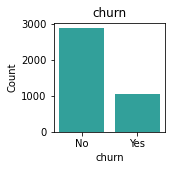

    churn  Count  Percent
No     No   2891    73.43
Yes   Yes   1046    26.57
_________________________________________________________________


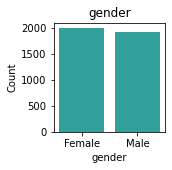

        gender  Count  Percent
Male    Female   2002    50.85
Female    Male   1935    49.15
_________________________________________________________________


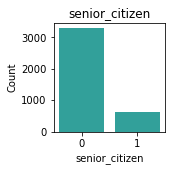

   senior_citizen  Count  Percent
0               0   3290    83.57
1               1    647    16.43
_________________________________________________________________


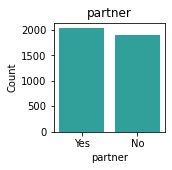

    partner  Count  Percent
No      Yes   2033    51.64
Yes      No   1904    48.36
_________________________________________________________________


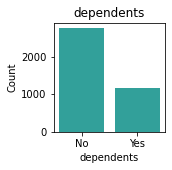

    dependents  Count  Percent
No          No   2764    70.21
Yes        Yes   1173    29.79
_________________________________________________________________


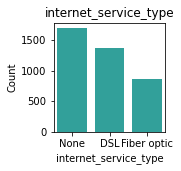

            internet_service_type  Count  Percent
Fiber optic                  None   1698    43.13
DSL                           DSL   1368    34.75
None                  Fiber optic    871    22.12
_________________________________________________________________


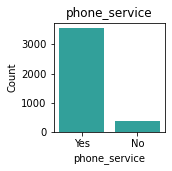

    phone_service  Count  Percent
Yes           Yes   3548    90.12
No             No    389     9.88
_________________________________________________________________


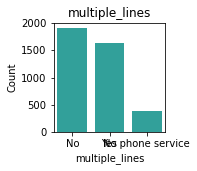

                    multiple_lines  Count  Percent
No                              No   1906    48.41
Yes                            Yes   1642    41.71
No phone service  No phone service    389     9.88
_________________________________________________________________


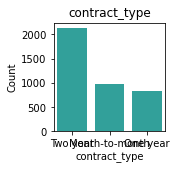

                 contract_type  Count  Percent
Month-to-month        Two year   2135    54.23
Two year        Month-to-month    972    24.69
One year              One year    830    21.08
_________________________________________________________________


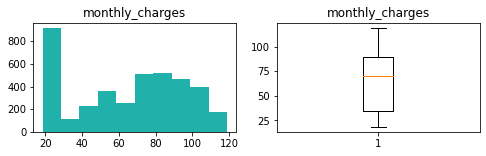

count    3937.000000
mean       64.191046
std        30.129425
min        18.550000
25%        34.950000
50%        69.950000
75%        89.450000
max       118.750000
Name: monthly_charges, dtype: float64


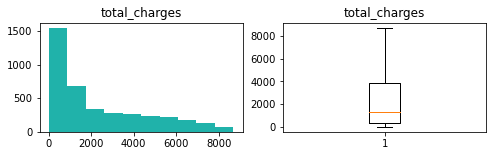

count    3937.000000
mean     2281.487668
std      2287.371123
min        18.800000
25%       371.400000
50%      1359.700000
75%      3827.900000
max      8684.800000
Name: total_charges, dtype: float64


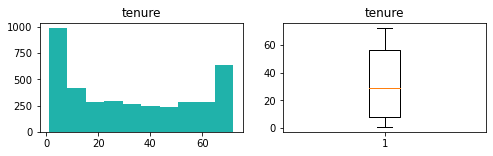

count    3937.000000
mean       32.505715
std        24.773712
min         1.000000
25%         8.000000
50%        29.000000
75%        56.000000
max        72.000000
Name: tenure, dtype: float64


In [37]:
explore.explore_univariate(train, cat_vars, quant_vars)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fbca3ee4610>,
 'caps': [<matplotlib.lines.Line2D at 0x7fbca3ee4d00>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fbca3ee42b0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fbca40d4730>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fbca40d4e50>],
 'means': []}

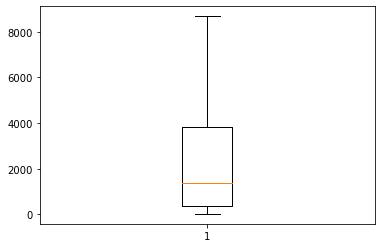

In [38]:
plt.boxplot(train.total_charges)

In [39]:
train.dtypes

customer_id               object
gender                    object
senior_citizen             int64
partner                   object
dependents                object
tenure                     int64
phone_service             object
multiple_lines            object
monthly_charges          float64
total_charges            float64
churn                     object
contract_type             object
internet_service_type     object
payment_type              object
dtype: object

In [40]:
cat_vars = ['senior_citizen']

In [41]:
quant_vars = ['monthly_charge','tenure','total_charges']

In [44]:
#change churn to 0 or 1
#explore.explore_bivariate(train, 'churn', cat_vars, quant_vars)
train.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
6096,8966-SNIZF,Female,0,Yes,No,70,Yes,No,19.45,1303.50,No,Two year,None,Bank transfer (automatic)
1603,3466-BYAVD,Male,0,Yes,Yes,15,Yes,No,69.50,1071.40,No,Month-to-month,DSL,Mailed check
5350,9278-VZKCD,Female,1,Yes,No,52,Yes,Yes,109.10,5647.95,No,Month-to-month,Fiber optic,Electronic check
2068,7074-STDCN,Male,0,No,No,39,No,No phone service,40.60,1494.50,No,Month-to-month,DSL,Electronic check
6366,5914-GXMDA,Female,0,Yes,No,32,Yes,No,19.30,593.20,No,One year,None,Mailed check


In [45]:
def explore_multivariate(train, churn, cat_vars, quant_vars):
    '''
    '''
    plot_swarm_grid_with_color(train, churn, cat_vars, quant_vars)
    plt.show()
    violin = plot_violin_grid_with_color(train, churn, cat_vars, quant_vars)
    plt.show()
    pair = sns.pairplot(data=train, vars=quant_vars, hue=churn)
    plt.show()
    plot_all_continuous_vars(train, churn, quant_vars)
    plt.show()    

In [46]:
target = 'churn'

In [48]:
#explore.explore_multivariate(train, 'churn', cat_vars, quant_vars)

**Descriptive stats, frequencies, histograms Takeaways**

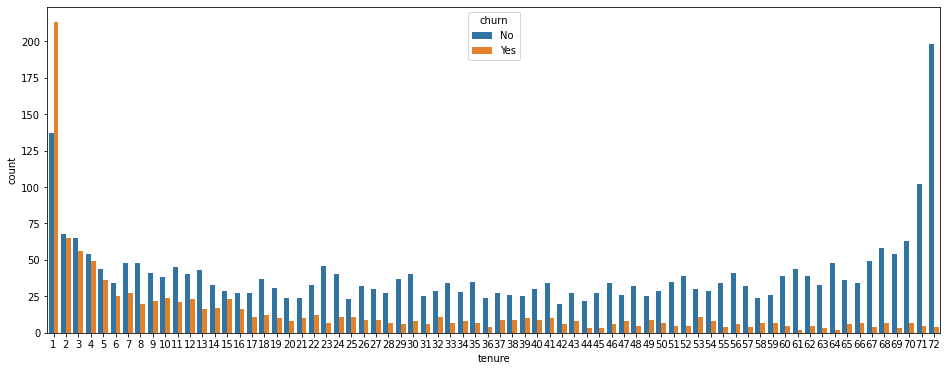

In [49]:
plt.figure(figsize=(16, 6)) # changes the size of the figure
sns.countplot(data=train, x='tenure', hue='churn')
plt.show()

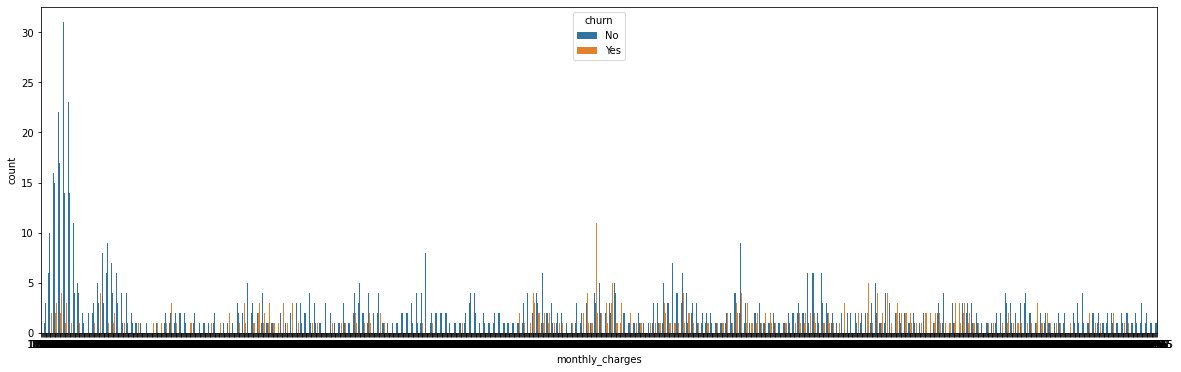

In [50]:
# plot monthly_charges by churn
plt.figure(figsize=(20, 6))
sns.countplot(data=train, x='monthly_charges', hue='churn')
plt.show()

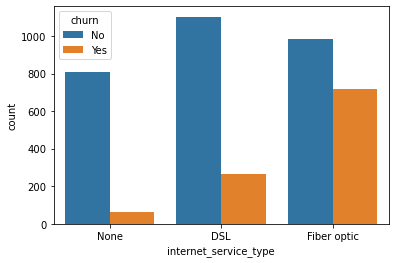

In [51]:
# plot internet_service_type by churn
sns.countplot(data=train, x='internet_service_type', hue='churn')
plt.show()

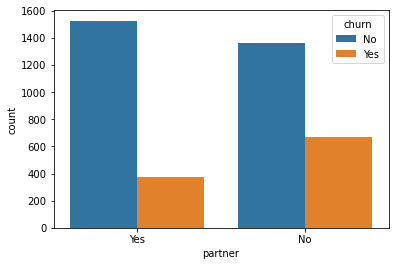

In [52]:
# plot with or without partner by churn
sns.countplot(data=train, x='partner',hue='churn')
plt.show()

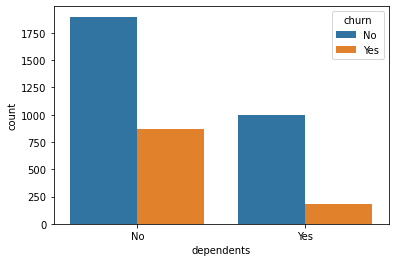

In [53]:
# plot with or without dependents by churn
sns.countplot(data=train, x='dependents', hue='churn')
plt.show()

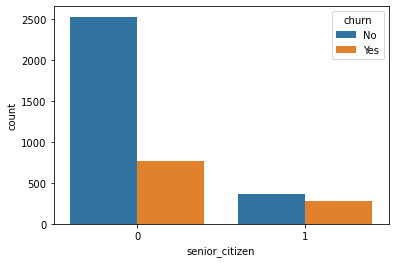

In [54]:
# plot senior_citizen by churn
sns.countplot(data=train, x='senior_citizen', hue='churn')
plt.show()

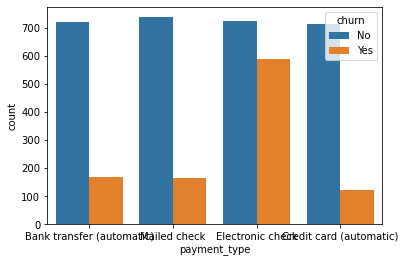

In [55]:
# plot payment_type by churn
sns.countplot(data=train, x='payment_type', hue='churn')
plt.show()

**Countplot Takeaways**
-tenure is by far highest at one month and by far least at 72 months
-customers with the lowest monthly bills are churning the most
-fiber optics service type churns at a rate by far higher than the other two
-those customers without partners churn at a much higher rate
-customers with dependents churn at a slightly higher rate
-seniors churn at a much higher rate than other customers
-customers who pay with electronic check churn near as much as all the other 3 payment types combined

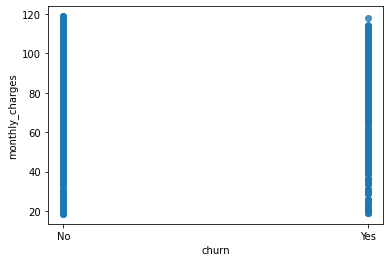

In [57]:
#let's look at some more visualizations
A = sns.regplot(x=train['churn'], y=train['monthly_charges'], fit_reg=False)

<AxesSubplot:xlabel='churn', ylabel='tenure'>

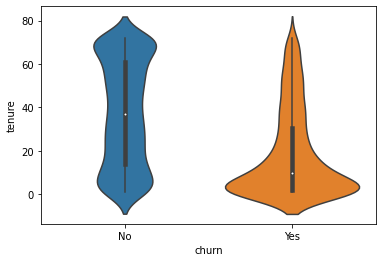

In [58]:
sns.violinplot(x=train["churn"], y=train["tenure"])

<AxesSubplot:xlabel='churn', ylabel='monthly_charges'>

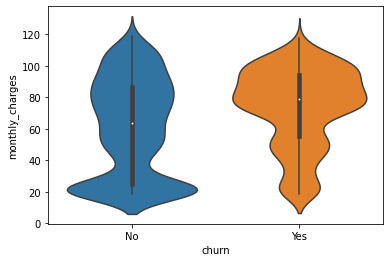

In [59]:
sns.violinplot(x=train["churn"], y=train["monthly_charges"])

**Violinplot takeaways**
-churn is much higher at the lowesst tenure
-churn is higher for customers with higher monthly charges

AttributeError: module 'seaborn' has no attribute 'plt'

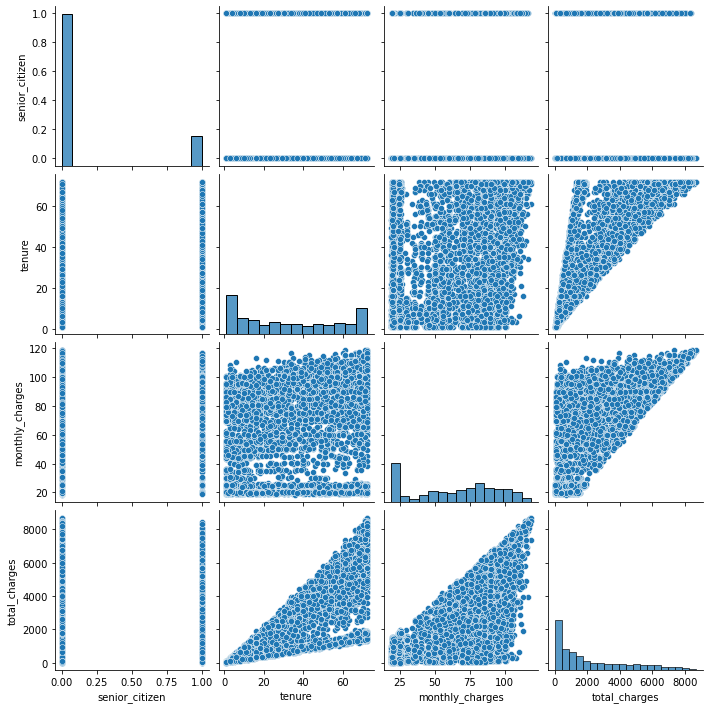

In [60]:
# make a correlogram
sns.pairplot(train)
sns.plt.show()

In [ ]:
sns.pairplot(train, hue='churn')
plt.show()

**Takeaway from pairplot**
-customers churn more often at the lower tenures
-customers churn the lesast with high monthly bills and high tenure
-senior citizens with all types of tenure churn at a similar rate unlike the rest of the population that mostly churns at a lower tenure

In [ ]:
#####################################################Statistical Testing

Hypothesis 1: Let's see if there is a relationship between payment type and churn.
$H_0$: There is no relationship between payment type and churn, they are independent. 
$H_a$: There is a relationship between payment type and churn, they are dependent on each other. 

Hypothesis 2: Let's see if there is a relationship between being a senior citizen and churn.
alpha = .05
$H_0$: There is no relationship between being a senior citizen or not and churn, they are independent. 
$H_a$: There is a relationship between beinga a senior citizen or not and churn, they are dependent on each other.

In [ ]:
train.churn.replace(to_replace=['Yes','No'],value=[1,0], inplace=True)

In [61]:
validate.churn.replace(to_replace=['Yes','No'],value=[1,0], inplace=True)

In [62]:
test.churn.replace(to_replace=['Yes','No'],value=[1,0], inplace=True)

In [63]:
train.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
6096,8966-SNIZF,Female,0,Yes,No,70,Yes,No,19.45,1303.50,No,Two year,None,Bank transfer (automatic)
1603,3466-BYAVD,Male,0,Yes,Yes,15,Yes,No,69.50,1071.40,No,Month-to-month,DSL,Mailed check
5350,9278-VZKCD,Female,1,Yes,No,52,Yes,Yes,109.10,5647.95,No,Month-to-month,Fiber optic,Electronic check
2068,7074-STDCN,Male,0,No,No,39,No,No phone service,40.60,1494.50,No,Month-to-month,DSL,Electronic check
6366,5914-GXMDA,Female,0,Yes,No,32,Yes,No,19.30,593.20,No,One year,None,Mailed check


In [64]:
# calculate baseline_accuracy
baseline_accuracy=(train.churn == 0).mean()
round(baseline_accuracy,2) 

0.0

In [65]:
# make dummy variable for senior_citizen and payment_type

dummy_df = pd.get_dummies(df[['senior_citizen','payment_type']])
dummy_df.head()

,senior_citizen,payment_type_Bank transfer (automatic),payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
0,0,0,0,0,1
1,0,0,1,0,0
2,0,1,0,0,0
3,0,0,1,0,0
4,0,1,0,0,0


In [66]:
# concatenate the dummy_df dataframe above with the original df 

df = pd.concat([df, dummy_df], axis=1)
df.head(1)

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type,senior_citizen,payment_type_Bank transfer (automatic),payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
0,0016-QLJIS,Female,0,Yes,Yes,65,Yes,Yes,90.45,5957.9,No,Two year,DSL,Mailed check,0,0,0,0,1


In [67]:
# test hypothesis 1

In [68]:
#set alpha to .05
a = .05

In [69]:
observed = pd.crosstab(train.churn, train.payment_type)
observed

payment_type,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check
churn,,,,
No,719,712,723,737
Yes,170,122,588,166


In [70]:
chi2, p ,degf, expected = stats.chi2_contingency(observed)
chi2, p

(341.8332932781657, 8.748945233390548e-74)

In [71]:
if p < a:
    print("Reject null hypothesis, payment type and churn are not independent")
else:
    print("Fail to reject null hypothesis, payment type and churn are independent, let's keep finding features that are not.")

Reject null hypothesis, payment type and churn are not independent


In [72]:
train.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
6096,8966-SNIZF,Female,0,Yes,No,70,Yes,No,19.45,1303.50,No,Two year,None,Bank transfer (automatic)
1603,3466-BYAVD,Male,0,Yes,Yes,15,Yes,No,69.50,1071.40,No,Month-to-month,DSL,Mailed check
5350,9278-VZKCD,Female,1,Yes,No,52,Yes,Yes,109.10,5647.95,No,Month-to-month,Fiber optic,Electronic check
2068,7074-STDCN,Male,0,No,No,39,No,No phone service,40.60,1494.50,No,Month-to-month,DSL,Electronic check
6366,5914-GXMDA,Female,0,Yes,No,32,Yes,No,19.30,593.20,No,One year,None,Mailed check


In [73]:
#copy the train dataset
train_encoded = train.copy()

In [74]:
encoded_columns = ['gender','contract_type','partner','dependents','phone_service','multiple_lines','internet_service_type','payment_type']

In [75]:
#make dummy variables
dummy_df = pd.get_dummies(train_encoded[encoded_columns], dummy_na=False, drop_first=[True, True])

In [76]:
# put it all back together
train_encoded = pd.concat([train_encoded, dummy_df], axis=1)

In [79]:
# drop initial column since we have that information now
train_encoded = train_encoded.drop(columns=encoded_columns)

KeyError: "['gender' 'contract_type' 'partner' 'dependents' 'phone_service'\n 'multiple_lines' 'internet_service_type' 'payment_type'] not found in axis"

In [ ]:
# do the same for validate and test sets

In [80]:
# copy the validate dataset
validate_encoded = validate.copy()

In [81]:
#make dummy variables
dummy_df = pd.get_dummies(validate_encoded[encoded_columns], dummy_na=False, drop_first=[True, True])

In [82]:
# put it all back together
validate_encoded = pd.concat([validate_encoded, dummy_df], axis=1)

In [83]:
# drop initial column since we have that information now
validate_encoded = validate_encoded.drop(columns=encoded_columns)

In [84]:
# copy the test dataset
test_encoded = test.copy()

In [85]:
#make dummy variables
dummy_df = pd.get_dummies(test_encoded[encoded_columns], dummy_na=False, drop_first=[True, True])

In [86]:
# put it all back together
test_encoded = pd.concat([test_encoded, dummy_df], axis=1)

In [87]:
# drop initial column since we have that information now
test_encoded = test_encoded.drop(columns=encoded_columns)

In [88]:
train_encoded.head()

,customer_id,senior_citizen,tenure,monthly_charges,total_charges,churn,gender_Male,contract_type_One year,contract_type_Two year,partner_Yes,dependents_Yes,phone_service_Yes,multiple_lines_No phone service,multiple_lines_Yes,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
6096,8966-SNIZF,0,70,19.45,1303.50,No,0,0,1,1,0,1,0,0,0,1,0,0,0
1603,3466-BYAVD,0,15,69.50,1071.40,No,1,0,0,1,1,1,0,0,0,0,0,0,1
5350,9278-VZKCD,1,52,109.10,5647.95,No,0,0,0,1,0,1,0,1,1,0,0,1,0
2068,7074-STDCN,0,39,40.60,1494.50,No,1,0,0,0,0,0,1,0,0,0,0,1,0
6366,5914-GXMDA,0,32,19.30,593.20,No,0,1,0,1,0,1,0,0,0,1,0,0,1


In [89]:
#test hypothesis 2

In [90]:
#set alpha to .05
a = .05

In [91]:
observed = pd.crosstab(train.churn, train.senior_citizen)
observed

senior_citizen,0,1
churn,,
No,2524,367
Yes,766,280


In [92]:
chi2, p ,degf, expected = stats.chi2_contingency(observed)
chi2, p

(109.76347560274587, 1.1040911367340458e-25)

In [93]:
if p < a:
    print("Reject null hypothesis, payment type and churn are not independent")
else:
    print("Fail to reject null hypothesis, payment type and churn are independent, let's keep finding features that are not.")

Reject null hypothesis, payment type and churn are not independent


In [94]:
########################### Model & Evaluate

In [95]:
train_encoded.head()

,customer_id,senior_citizen,tenure,monthly_charges,total_charges,churn,gender_Male,contract_type_One year,contract_type_Two year,partner_Yes,dependents_Yes,phone_service_Yes,multiple_lines_No phone service,multiple_lines_Yes,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
6096,8966-SNIZF,0,70,19.45,1303.50,No,0,0,1,1,0,1,0,0,0,1,0,0,0
1603,3466-BYAVD,0,15,69.50,1071.40,No,1,0,0,1,1,1,0,0,0,0,0,0,1
5350,9278-VZKCD,1,52,109.10,5647.95,No,0,0,0,1,0,1,0,1,1,0,0,1,0
2068,7074-STDCN,0,39,40.60,1494.50,No,1,0,0,0,0,0,1,0,0,0,0,1,0
6366,5914-GXMDA,0,32,19.30,593.20,No,0,1,0,1,0,1,0,0,0,1,0,0,1


In [97]:
# create X & y version of encoded_train, where y is a series with just the target variable and X are all the features. 

X_train = train_encoded.drop(columns=['churn','customer_id'])
y_train = train_encoded.churn

X_validate = validate_encoded.drop(columns=['churn','customer_id'])
y_validate = validate_encoded.churn

X_test = test_encoded.drop(columns=['churn','customer_id'])
y_test = test_encoded.churn

In [98]:
X_train.head()

,senior_citizen,tenure,monthly_charges,total_charges,gender_Male,contract_type_One year,contract_type_Two year,partner_Yes,dependents_Yes,phone_service_Yes,multiple_lines_No phone service,multiple_lines_Yes,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
6096,0,70,19.45,1303.50,0,0,1,1,0,1,0,0,0,1,0,0,0
1603,0,15,69.50,1071.40,1,0,0,1,1,1,0,0,0,0,0,0,1
5350,1,52,109.10,5647.95,0,0,0,1,0,1,0,1,1,0,0,1,0
2068,0,39,40.60,1494.50,1,0,0,0,0,0,1,0,0,0,0,1,0
6366,0,32,19.30,593.20,0,1,0,1,0,1,0,0,0,1,0,0,1


In [99]:
#create the model
clf = DecisionTreeClassifier(max_depth=3, random_state=123)

In [100]:
# fit the model
clf = clf.fit(X_train, y_train)

In [101]:
# make prediction on train obeservations

y_pred = clf.predict(X_train)
y_pred[0:5]

array(['No', 'No', 'No', 'No', 'No'], dtype=object)

In [102]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.79


In [103]:
# confusion matrix

confusion_matrix(y_train, y_pred)

array([[2704,  187],
       [ 633,  413]])

In [104]:
y_train.value_counts()

No     2891
Yes    1046
Name: churn, dtype: int64

In [105]:
labels = sorted(y_train.unique())

pd.DataFrame(confusion_matrix(y_train, y_pred), index=labels, columns=labels)

,No,Yes
No,2704,187
Yes,633,413


In [106]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

          No       0.81      0.94      0.87      2891
         Yes       0.69      0.39      0.50      1046

    accuracy                           0.79      3937
   macro avg       0.75      0.67      0.69      3937
weighted avg       0.78      0.79      0.77      3937



predict returns a series that we can name predictions and then add that back onto df and df.to_csv(filename) to
write it to a csv